# RNN

RNN은 은닉층의 노드에서 활성화 함수를 통해 나온 결과값을 출력층 방향으로도 보내면서, 다시 은닉층 노드의 다음 계산의 입력으로 보내는 특징을 갖고있습니다.

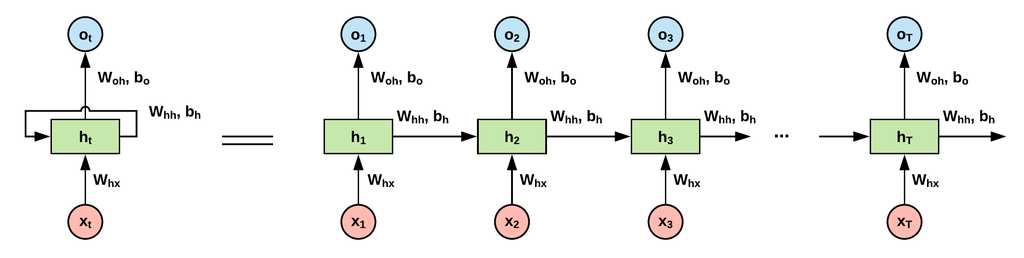

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

## 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd/content/gdrive/My Drive/Deep_learning_K&P

/content/gdrive/My Drive/Deep_learning_K&P


In [ ]:
df = pd.read_csv("./data/kospi.csv")

Open, High, Low, Close, Adj Close는 금액, Volume은 거래량으로 데이터의 단위가 다르다.

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


MixMaxScaler를 통해서 데이터를 0과1사이로 scaling을 해준다.

In [ ]:
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


총 431개의 데이터 존재

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


## 텐서 데이터 만들기

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
# Dataset
# 시가, 최고가, 최저가, 거래량 을 이용해서 종가(마지막으로 체결된 거개가격) 예측

X = df[['Open','High','Low','Volume']].values
y = df['Close'].values

특정일자로 부터 Sequence length 만큼의 데이터를 입력데이터로 설정하고, Sequence length 이후의 데이터를 출력변수로 설정한다.

In [ ]:
def seq_data(x, y, sequence_length):
    
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) 
        y_seq.append(y[i+sequence_length])
    
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

200개를 전후로 학습데이터와 평가데이터로 나눈다.

In [ ]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

## Hyperparameter 설정

In [ ]:
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

## 모델 구축

In [ ]:
class VanillaRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device =device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) 
        # pytorch에서 rnn의 입력 데이터는 [sequence 길이, batch_size, 변수의 크기]로 들어와야한다.
        # batch_first = True를 통해서 데이터의 순서를 바꾸지 않고 그대로 입력할 수 있게 한다.
        self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로 부터 나온 output feature 반환, hn: hidden state 반환
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [ ]:
model = VanillaRNN(input_size=input_size, 
                   hidden_size=hidden_size, 
                   sequence_length=sequence_length, 
                   num_layers=num_layers, 
                   device=device).to(device)

In [ ]:
print(model)

VanillaRNN(
  (rnn): RNN(4, 8, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=40, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [ ]:
criterion = nn.MSELoss().to(device) ## 연속적인 값을 예측하는 regression문제 이기 때문에 MSE를 손실함수로 적용

lr = 1e-3
num_epochs = 200 
optimizer = optim.Adam(model.parameters(), lr=lr)

## 모델 학습하기

In [ ]:
loss_graph = []
n = len(train_loader)
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        
        seq, target = data # 배치 데이터
         
        optimizer.zero_grad()
        out = model(seq)
        loss = criterion(out, target)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.0289
[epoch: 10] loss: 0.0069
[epoch: 20] loss: 0.0065
[epoch: 30] loss: 0.0060
[epoch: 40] loss: 0.0052
[epoch: 50] loss: 0.0035
[epoch: 60] loss: 0.0014
[epoch: 70] loss: 0.0011
[epoch: 80] loss: 0.0011
[epoch: 90] loss: 0.0010
[epoch: 100] loss: 0.0010
[epoch: 110] loss: 0.0010
[epoch: 120] loss: 0.0010
[epoch: 130] loss: 0.0010
[epoch: 140] loss: 0.0010
[epoch: 150] loss: 0.0010
[epoch: 160] loss: 0.0010
[epoch: 170] loss: 0.0009
[epoch: 180] loss: 0.0009
[epoch: 190] loss: 0.0009


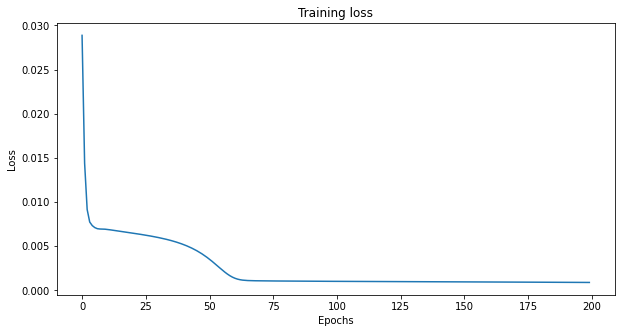

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(loss_graph)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show() 

## 결과 시각화


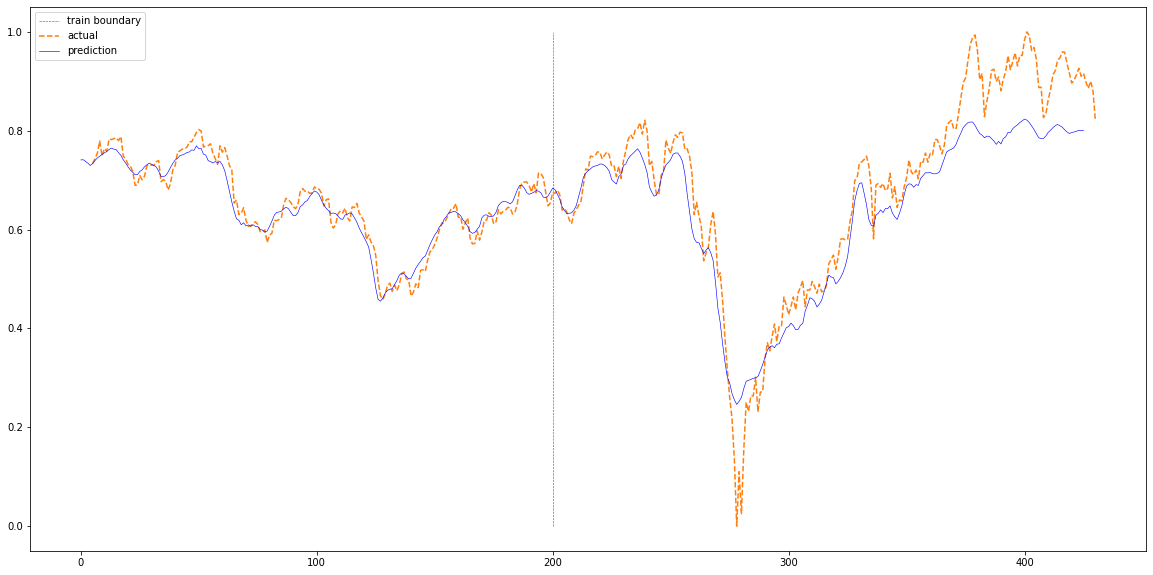

In [ ]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():

        model.eval()
        train_pred = []
        test_pred = []
   
        for data in train_loader:
            seq, target = data
            out = model(seq).to(device)
            train_pred += out.tolist()
            
        for data in test_loader:
            seq, target = data 
            out = model(seq).to(device)
            test_pred += out.tolist()
    total = train_pred+test_pred       
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred),np.linspace(0,1,100),'--', linewidth=0.6)
    plt.plot(actual,'--')
    plt.plot(total,'b', linewidth=0.6)
    
    
    plt.legend(['train boundary','actual','prediction'])
    plt.show() 
    
plotting(train_loader, test_loader, df['Close'][sequence_length:])